# Sec 1
Import libs used for Chinese topic modelling (jieba, gensim, and pyLDAvis)

In [14]:
# Chinese LDA for plot summaries
# Based on https://blog.csdn.net/weixin_39876856/article/details/111646357
# and https://www.cnblogs.com/zongfa/p/9556471.html
import jieba
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim import corpora, models, similarities

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import json
import urllib.request

Load film data from main JSON and initialise stop word list

NAME_STOPPING_SOURCE can be "Entities" (stop 615 names detected by NamedEntity Recognition), "Characters" (stop all 7150 fictional character names documented in The Catalogue of Chinese Art Films), or "None"

"Characters" might cause slowness but is the most accurate one.

In [15]:
NAME_STOPPING_SOURCE = "None"

with open("../../metadata-all.json") as f:
    films = json.load(f)["films"]

print("Total number of films: ", len(films))

# Print all films in the dataset to check if it is loaded correctly
for [i, film] in enumerate(films):
	print("{} [{}] ({})".format(film["title"], film["translated"], film["year"]))
        
def stop_words():
	stopwords = []
	# Stop word for Chiense, list 1
	url_data = urllib.request.urlopen("https://raw.githubusercontent.com/stopwords-iso/stopwords-zh/master/stopwords-zh.txt")
	for line in url_data:
		#print(line.decode("utf-8"))
		word = line.decode("utf-8")
		if word not in stopwords:
			stopwords.append(word)

	# Stop word for Chiense, list 2
	url_data2 = urllib.request.urlopen("https://raw.githubusercontent.com/wanghaing/project-model-LDA/master/data/stop_word/stop_word%EF%BC%88utf8%EF%BC%89.txt")
	for line in url_data2:
		#print(line.decode("utf-8"))
		word = line.decode("utf-8")
		if word not in stopwords:
			stopwords.append(word)

	# An extra stop word list designed for old Chinese film plot summaries
	extra_list = open("../extra-stopwords.txt", "r", encoding="utf-8")
	for line in extra_list:
		if line not in stopwords:
			stopwords.append(line)
	
	if NAME_STOPPING_SOURCE == "Characters":
		entity_list = open("../ultimate_character_list(bianmu).txt", "r", encoding="utf-8")
		for line in entity_list:
			if line not in stopwords:
				stopwords.append(line)
	elif NAME_STOPPING_SOURCE == "Entities":
		# A list of entity names generated from the film metadata with Baidi API
		# Adding this list may decrease the readability of extracted topics
		entity_list = open("../plot_entities.txt", "r", encoding="utf-8")
		for line in entity_list:
			if line not in stopwords:
				stopwords.append(line)

	stopwords = [x.strip() for x in stopwords]
	print("{} stop words loaded".format(len(stopwords)))
	return stopwords

def tokenize(text, stop_words):
	#Remove all spaces, {LINE_CUT}, {COMMA}, {QUOTE} symbols in the text
	text = text.replace(" ", "").replace("{LINE_CUT}", "").replace("{COMMA}", "").replace("{QUOTE}", "").replace("”", "").replace("\n", "").replace('“', "")

	segmented = jieba.cut(text.strip())
	output = ""
	for seg in segmented:
		# Add one segment only if it is not a stop word and longer than 1 character
		if seg not in stop_words and len(seg) > 1:
				output += seg + " "
	return output

stop_words = stop_words()

Total number of films:  732
桥 [The Bridge] (1949)
回到自己队伍来 [Return to Our Army] (1949)
光芒万丈 [Light Spreads Everywhere] (1949)
中华女儿 [Daughters of China] (1949)
白衣战士 [Fighter in White] (1949)
无形的战线 [The Invisible Front Line] (1949)
表 [The Watch (aka An Orphan on the Streets)] (1949)
二百五小传 [The Story of a Foolish Man (aka The Heroic Opera Performer)] (1949)
乌鸦与麻雀 [Crows and Sparrows] (1949)
三毛流浪记 [The Story of “Three Hair” the Vagrant] (1949)
赵一曼 [Zhao Yiman] (1950)
光荣人家 [Honorable Family] (1950)
卫国保家 [Protecting Home Through the Nation] (1950)
红旗歌 [Song of the Red Flag] (1950)
钢铁战士 [Steeled Fighters] (1950)
高歌猛进 [Aggressively Moving Forward] (1950)
刘胡兰 [Liu Hulan] (1950)
辽远的乡村 [A Remote Village] (1950)
内蒙人民的胜利 [Victory for the People of Inner Mongolia] (1950)
白毛女 [The White-Haired Girl] (1950)
人民的战士 [People’s Soldiers] (1950)
保卫胜利果实 [Guarding the Fruits of Victory] (1950)
在前进的道路上 [On the Progressive Road] (1950)
吕梁英雄 [Heros of Lvliang] (1950)
鬼神不灵 [Ghosts Don’t Exist] (1950)
民主青年进行曲 [Demo

# Sec 2
Setting the setting(s) in the cell below to adjust the results

In [16]:
# Whether all films or only features should be analysed
# (Disabling this option seems to result in higher coherence scores)
FEATURE_FILM_ONLY = False

# Whether to apply the topic model per word or per topic
# An attribute in LDA model
APPLY_PER_WORD_TOPIC = True

Tokenise the plot summaries and print all

In [17]:
results = []
film_keys = []

i = 0

for film in films:
	if(film["reels"] > 0) : continue # All films in extra have no reels information
	if FEATURE_FILM_ONLY and film["filmType"] != "Feature":
		print("Skipping film {} as it is not a feature film".format(film["title"]))
		continue
	film_keys.append(film["key"])
	plot = film["plot"]
	str = tokenize(plot, stop_words)
	if str != "":
		results.append([i, str])
		i += 1

print("\nTotal number of film plots loaded: ", len(results))
results = [n[1].split(" ")[:-1] for n in results]


Total number of film plots loaded:  76


Initialise "The Bag of Words" and LDA based on the tokenised plot summaries

In [18]:
word_bag = corpora.Dictionary(results)
corpus = [word_bag.doc2bow(text) for text in results]

#print([[(word_bag[id], freq) for id, freq in cp] for cp in corpus[:1]])

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
										   id2word=word_bag,
                                           num_topics=40,
                                           per_word_topics=APPLY_PER_WORD_TOPIC)

#pprint(lda_model.print_topics(num_words=20))

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=results, dictionary=word_bag, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.371492309619672

Coherence Score:  0.4629022310426829


Filter topics
(Suggested TOPIC_RANGE=46; TOPIC_STEP=5)
(Or TOPIC＿RANGE＝21; TOPIC_STEP=2 for more compact results when FEATURE_FILM_ONLY is off)

In [19]:
TOPIC_RANGE = 61
TOPIC_STEP = 5
ITERATION = 800

coherence_values = []
perplexity_values = []
model_list = []
for num_topics in range(TOPIC_STEP, TOPIC_RANGE, TOPIC_STEP):
	model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=word_bag, num_topics=num_topics,
					 						per_word_topics=APPLY_PER_WORD_TOPIC,
											iterations=ITERATION, eval_every=None, eta='auto',
											chunksize=5000, passes=40)
	model_list.append(model)
	coherencemodel = CoherenceModel(model=model, texts=results, dictionary=word_bag, coherence='c_v')
	coherence_values.append(round(coherencemodel.get_coherence(), 3))
	perplexity_values.append(round(model.log_perplexity(corpus), 3))


# Sec 3
## Results Output #1 (Parallel):
Get the best range of topic numbers

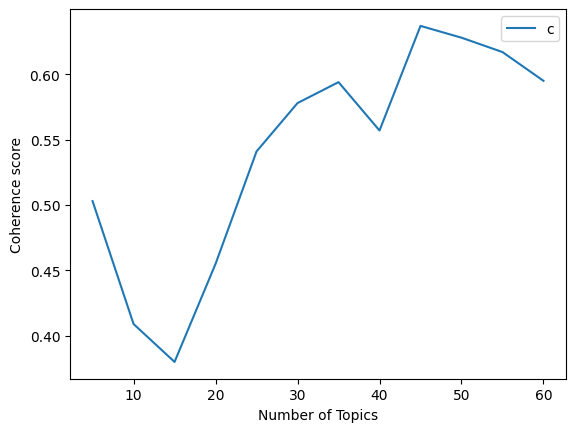

In [20]:
# Show graph
x = range(TOPIC_STEP, TOPIC_RANGE, TOPIC_STEP)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Sec 3
## Results Output #2 (Parallel):
Visualise attributes of optimal model

In [21]:
optimal_model = model_list[coherence_values.index(max(coherence_values))]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=20))

print("\n")

[(30,
  '0.029*"看相" + 0.022*"写状" + 0.014*"卖婆记" + 0.014*"贩马记" + 0.014*"女子" + '
  '0.014*"赵宠" + 0.014*"越剧" + 0.014*"两名" + 0.014*"金彩" + 0.014*"李阿大" + '
  '0.014*"老婆" + 0.007*"菁华" + 0.007*"被判" + 0.007*"继母" + 0.007*"纨绔子弟" + '
  '0.007*"秋后" + 0.007*"看穿" + 0.007*"躲过" + 0.007*"虽借" + 0.007*"楼台"'),
 (11,
  '0.035*"宝莲" + 0.021*"严仲甫" + 0.014*"摆脱" + 0.014*"叶复" + 0.007*"下海" + '
  '0.007*"不幸" + 0.007*"如云" + 0.007*"控制" + 0.007*"宝莲受" + 0.007*"宝莲想" + '
  '0.007*"家境贫寒" + 0.007*"家门" + 0.007*"富家" + 0.007*"年头" + 0.007*"很快" + '
  '0.007*"徐尤耕" + 0.007*"快点" + 0.007*"圈套" + 0.007*"介绍" + 0.007*"历经"'),
 (10,
  '0.031*"周水" + 0.020*"姚蔷" + 0.010*"晨起" + 0.010*"开学" + 0.010*"两个" + 0.010*"出门" '
  '+ 0.010*"面貌" + 0.010*"想起" + 0.010*"惴惴不安" + 0.010*"教授" + 0.010*"院里" + '
  '0.010*"某大学" + 0.010*"正待" + 0.010*"灌溉" + 0.010*"生日" + 0.010*"男子" + '
  '0.010*"蔷薇" + 0.010*"1949" + 0.010*"30" + 0.010*"不禁"'),
 (26,
  '0.015*"郝福元" + 0.015*"郝家" + 0.015*"郝二虎" + 0.015*"铁狗" + 0.015*"百姓" + '
  '0.015*"金山" + 0.008*"秘密" + 0.008*"团长" + 0.008*"地主

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, word_bag, mds="mmds")
vis

/Users/caoshuangyuan/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.302957  0.214681       1        1  7.082614
43    -0.338382  0.069461       2        1  6.957683
12    -0.239733 -0.281081       3        1  6.748321
13    -0.070442 -0.323900       4        1  4.929384
29     0.217099 -0.264732       5        1  4.845765
40     0.075699 -0.315617       6        1  4.678657
38     0.112137  0.318451       7        1  4.594406
18    -0.300196 -0.083505       8        1  3.715600
34     0.176216  0.251652       9        1  3.652931
7     -0.150677  0.264270      10        1  3.611655
31    -0.031538  0.290585      11        1  3.047258
1      0.174609 -0.195912      12        1  2.942895
3      0.261161 -0.120647      13        1  2.920614
28     0.283246  0.029169      14        1  2.774763
5      0.216244  0.163873      15        1  2.691078
4      0.253914 -0.035626      16        1  2.588212
23     0.246189  0.094970      17        1  2.502915
41    -0.234502  0.023594      18        1  2.356577
15    -0.207909 -0.122844      19        1  2.335714
22    -0.004220 -0.219432      20        1  2.168430
25    -0.075909 -0.187447      21        1  1.980313
33    -0.140303 -0.119257      22        1  1.708583
32    -0.109452  0.161580      23        1  1.666020
21     0.030212  0.178688      24        1  1.562414
11     0.070546 -0.145927      25        1  1.561478
35     0.148821 -0.072704      26        1  1.520721
30    -0.029111  0.174131      27        1  1.477847
26     0.124096  0.087412      28        1  1.310591
20    -0.127635  0.085417      29        1  1.289684
0      0.063479  0.116589      30        1  1.185156
24    -0.087395  0.065074      31        1  1.122441
17    -0.087889 -0.046279      32        1  1.038824
37    -0.103827  0.009218      33        1  1.038824
9      0.103876  0.007241      34        1  0.976116
6     -0.029496 -0.081394      35        1  0.955214
14     0.049675 -0.064565      36        1  0.871610
39     0.019532  0.052173      37        1  0.725328
10     0.047278  0.011469      38        1  0.620868
27    -0.000351  0.001596      39        1  0.034642
19    -0.000351  0.001596      40        1  0.034642
36    -0.000351  0.001596      41        1  0.034642
8     -0.000351  0.001596      42        1  0.034642
42    -0.000351  0.001596      43        1  0.034642
2     -0.000351  0.001597      44        1  0.034642
44    -0.000351  0.001596      45        1  0.034642, topic_info=     Term       Freq      Total Category  logprob  loglift
2145   宋江  13.000000  13.000000  Default  30.0000  30.0000
1488   学校   8.000000   8.000000  Default  29.0000  29.0000
177    工作  14.000000  14.000000  Default  28.0000  28.0000
2263   大队   8.000000   8.000000  Default  27.0000  27.0000
1140   黄涛   5.000000   5.000000  Default  26.0000  26.0000
...   ...        ...        ...      ...      ...      ...
25     狂奔   0.000527   0.948182  Topic45  -8.0523   0.4735
26     玩弄   0.000527   1.656573  Topic45  -8.0523  -0.0844
27     生下   0.000527   1.710916  Topic45  -8.0523  -0.1167
28     相恋   0.000527   0.948182  Topic45  -8.0523   0.4735
29     知情   0.000527   1.770091  Topic45  -8.0523  -0.1507

[2096 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2915     20  0.913828    12
2628      7  0.797971  1944
580      15  0.873372  1948
581      15  0.691808  1949
582      15  0.873372    25
...     ...       ...   ...
2914     18  0.852106    黑影
1640      1  0.271367    鼓励
1640      2  0.542734    鼓励
1640      8  0.271367    鼓励
2552      4  0.985527    齐冲

[1749 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 44, 13, 14, 30, 41, 39, 19, 35, 8, 32, 2, 4, 29, 6, 5, 24, 42, 16, 23, 26, 34, 33, 22, 12, 36, 31, 27, 21, 1, 25, 18, 38, 10, 7, 15, 40, 11, 28, 20, 37, 9, 43, 3, 45])

In [23]:
def format_topics_sentences(ldamodel, corpus, texts):
    i = 0
    for item in corpus:
        f_key = film_keys[i]
        doc_tops = ldamodel.get_document_topics(item, minimum_probability=0.0)
        new_list = sorted(doc_tops, key=lambda x: x[1], reverse=True)
        # Iterate the new list and add the topics with highest probabilities to the list
        j = 0
        #max_prob = new_list[0][1]
        
        #dominant_tops = []
        
        #while j < len(new_list):
        #    if new_list[j][1] >= max_prob:
        #            j += 1
        #            dominant_tops.append(new_list[j][0])
        #    else:
        #            break
        dominant_tops = [new_list[0][0]]

        #get_document_topics = [dominant_top]
        print("|||FILM:{}|||TOPICS:{}|||TEXT:{}".format(f_key, dominant_tops, texts[i]))
        i += 1
	

format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=results)

|||FILM:ye lai feng yu sheng|||TOPICS:[0]|||TEXT:['少女', '晚霞', '中年男子', '赵伯翔', '相恋', '伯翔', '有妇之夫', '晚霞', '知情', '伯翔', '郑丽明', '离婚', '丽明', '自杀', '其兄', '救起', '晚霞', '得知', '震惊', '自责', '毅然', '返回', '家乡', '伯翔', '紧追不舍', '晚霞', '心软', '情网', '二人', '结婚', '伯翔', '贪财', '已有', '身孕', '晚霞', '抛弃', '富家女', '小姐', '香港', '晚霞', '生下', '一女', '营养不良', '夭折', '晚霞', '悲痛欲绝', '雪地', '狂奔', '晕倒', '伯翔', '无法忍受', '小姐', '玩弄', '归来', '晚霞', '撒手人寰']
|||FILM:sen lin da xue an|||TOPICS:[15]|||TEXT:['郊外', '密林', '中惊现', '女尸', '警察局长', '退休', '探长', '震中', '负责', '侦破', '震中', '不愿', '再见', '血腥', '推荐', '年轻有为', '职业', '侦探', '邬少卿', '不久以后', '震中', '之子', '少华', '邬少卿', '涉嫌', '杀人', '罪名', '逮捕', '震中', '无辜', '调查取证', '真相', '渐渐', '暴露', '被害', '少女', '白玉', '英是', '海外', '巨商', '唐启昌', '后代', '启昌', '留下', '遗嘱', '财产', '交给', '国内', '后代', '继承', '邬少卿', '兄妹', '冒领', '遗产', '将玉英', '杀害', '邬少卿', '警察', '激战', '中弹', '死去', '其妹', '受伤', '投降', '供出', '杀人', '冒领', '犯罪事实', '少华', '无罪释放']
|||FILM:han shan si zhong sheng|||TOPICS:[23]|||TEXT:['月夜', '热心', '船夫', '一名', '病重', '少妇', '寒山寺', '寺里', '胡老', '

The cell below prints all topics in each document with confidence

In [24]:
def format_all_topics_sentences(ldamodel, corpus, texts):
    i = 0
    for item in corpus:
        f_key = film_keys[i]
        doc_tops = ldamodel.get_document_topics(item, minimum_probability=0.0)
        new_list = sorted(doc_tops, key=lambda x: x[1], reverse=True)

        #get_document_topics = [dominant_top]
        print("|||FILM:{}|||TOPICS:{}|||TEXT:{}".format(f_key, new_list, texts[i]))
        i += 1
	

format_all_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=results)

|||FILM:ye lai feng yu sheng|||TOPICS:[(0, 0.98284566), (1, 0.00038987125), (2, 0.00038987125), (3, 0.00038987125), (4, 0.00038987125), (5, 0.00038987125), (6, 0.00038987125), (7, 0.00038987125), (8, 0.00038987125), (9, 0.00038987125), (10, 0.00038987125), (11, 0.00038987125), (12, 0.00038987125), (13, 0.00038987125), (14, 0.00038987125), (15, 0.00038987125), (16, 0.00038987125), (17, 0.00038987125), (18, 0.00038987125), (19, 0.00038987125), (20, 0.00038987125), (21, 0.00038987125), (22, 0.00038987125), (23, 0.00038987125), (24, 0.00038987125), (25, 0.00038987125), (26, 0.00038987125), (27, 0.00038987125), (28, 0.00038987125), (29, 0.00038987125), (30, 0.00038987125), (31, 0.00038987125), (32, 0.00038987125), (33, 0.00038987125), (34, 0.00038987125), (35, 0.00038987125), (36, 0.00038987125), (37, 0.00038987125), (38, 0.00038987125), (39, 0.00038987125), (40, 0.00038987125), (41, 0.00038987125), (42, 0.00038987125), (43, 0.00038987125), (44, 0.00038987125)]|||TEXT:['少女', '晚霞', '中年男子', '

# Sec 4 (Optional)

Save the optimal model in this run

In [25]:
optimal_model.save("../models/lda_model(extra_only).model")